# Mounting Google Drive to Colab

Here, we are going to connect our Google Drive to our Colab

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')
DIR = "/content/gdrive/My Drive/Career/Projects/PyTorch Nanodegree"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Configure Environment

In [0]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.1 LTS
Release:	18.04
Codename:	bionic


In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Tue_Jun_12_23:07:04_CDT_2018
Cuda compilation tools, release 9.2, V9.2.148


In [0]:
#install pytorch
!pip3 install torch torchvision

    100% |████████████████████████████████| 591.8MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61e5c000 @  0x7f382aeac2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 22.0MB/s 
    100% |████████████████████████████████| 2.0MB 6.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
#install pillow
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

    100% |████████████████████████████████| 5.7MB 6.1MB/s 
  Found existing installation: Pillow 5.4.0
    Uninstalling Pillow-5.4.0:
      Successfully uninstalled Pillow-5.4.0


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='/content/gdrive/My Drive/Career/Projects/PyTorch Nanodegree/assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
# Imports here
import os
import time
import copy
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
print("torch version: ", torch.__version__)
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets
from torchvision import transforms, models

torch version:  1.0.0


## 1) Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
data_dir = os.path.join(DIR, 'flower_data')
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')

In [0]:
# TODO: Define your transforms for the training and validation sets
train_transform = transforms.Compose([ transforms.RandomRotation(30), #random rotation [-30°:30°]
                                       transforms.Resize(255),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), 
                                                            (0.229, 0.224, 0.225))
                                      ])
valid_transform = transforms.Compose([ transforms.Resize(255),
                                       transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), 
                                                            (0.229, 0.224, 0.225))
                                      ])

# TODO: Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transform)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)

#combine these data loaders into a dictionary
dataloader = {'train': train_loader,
              'valid': valid_loader}

#get size of each group
dataset_sizes = {'train': len(train_dataset),
                 'valid': len(valid_dataset)}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [json module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

```
{'1': 'pink primrose',
 '10': 'globe thistle',
 '100': 'blanket flower',
 '101': 'trumpet creeper',
 '102': 'blackberry lily',
 '11': 'snapdragon',
 '12': "colt's foot",
 '13': 'king protea',
 '14': 'spear thistle',
 '15': 'yellow iris',
 '16': 'globe-flower',
 '17': 'purple coneflower',
 '18': 'peruvian lily',
 '19': 'balloon flower',
 '2': 'hard-leaved pocket orchid',
 '20': 'giant white arum lily',
 '21': 'fire lily',
 '22': 'pincushion flower',
 '23': 'fritillary',
 '24': 'red ginger'
 ...
```

In [0]:
import json

with open(os.path.join(DIR,'cat_to_name.json'), 'r') as f:
    cat_to_name = json.load(f)


In [0]:
def show_tensor_image(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

### Visualize Data

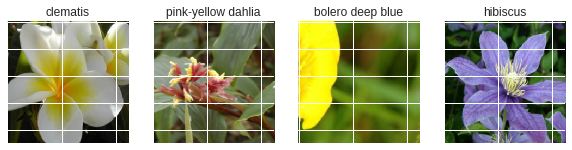

In [0]:
data_iter = iter(valid_loader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes[i]
    ax.set_title(cat_to_name[str(int(labels[i]))])
    show_tensor_image(images[i], ax=ax, normalize=True)

## 2) Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

### Load VGG19

Actually, VGG19 or any other pre-trained model in pytorch has two parts in it
- **Features**: which means using VGG19 like a feature-extractor like the Style Transfer part
```
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (19): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (20): ReLU(inplace)
  (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (22): ReLU(inplace)
  (23): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (24): ReLU(inplace)
  (25): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (26): ReLU(inplace)
  (27): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (29): ReLU(inplace)
  (30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (31): ReLU(inplace)
  (32): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (33): ReLU(inplace)
  (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (35): ReLU(inplace)
  (36): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
```
- **Classifier**: which means using VGG19 like a classifier which is what we are going to use here

```
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
```
As we can see, the last layer has 1000 as out features by default. And that is not going to work with us. Let's modify this to be just 102 which is the number of flower types we have in our dataset.

In [0]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:29<00:00, 19777016.65it/s]


In [0]:
#modify last layer
vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=len(cat_to_name.keys())) 

# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# move tensors to GPU if CUDA is available
vgg.to(device)

#get the 
vgg.class_to_idx = train_dataset.class_to_idx

### Define criterion, optimizer and scheduler

Here, we are going to define our criterion, optimizer and our scheduler

In [0]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

### Train our model

Now, I think VGG19 is ready for training... This [link](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) was pretty helpful regarding developing this part!!


In [0]:
def train_vgg(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
                 #scheduler.step()
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader[phase], desc=phase.upper()+" Epoch {}/{}".format(epoch+1, num_epochs)):
                #move data to cuda
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]

            # deep copy the model
            if phase == 'valid' :
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    #get only the weighs
                    best_model_wts = copy.deepcopy(model.state_dict())
                    #save the model
                    torch.save({'epoch': epoch,
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'loss': loss,
                                'class_to_idx': model.class_to_idx
                                }, os.path.join(DIR, 'checkpoint.pth'))
                    tqdm.write("Model Saved into checkpoint.pth")
                tqdm.write('{} Loss: {:.4f} Acc: {:.4f} Best Accuracy: {}'\
                           .format(phase, epoch_loss, epoch_acc, best_acc))
                tqdm.write("\n")
                

    time_elapsed = time.time() - since
    tqdm.write('Training complete !!')
    tqdm.write('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
vgg = train_vgg(vgg, criterion, optimizer, lr_scheduler, num_epochs=20)

TRAIN Epoch 2/20:   0%|          | 0/205 [00:00<?, ?it/s]

Model Saved into checkpoint.pth
valid Loss: 1.1033 Acc: 0.7115 Best Accuracy: 0.7114914425427873




TRAIN Epoch 3/20:   0%|          | 0/205 [00:00<?, ?it/s]

Model Saved into checkpoint.pth
valid Loss: 0.8090 Acc: 0.7726 Best Accuracy: 0.7726161369193154




TRAIN Epoch 4/20:   0%|          | 0/205 [00:00<?, ?it/s]

Model Saved into checkpoint.pth
valid Loss: 0.5691 Acc: 0.8533 Best Accuracy: 0.8533007334963325




TRAIN Epoch 5/20:   0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.5710 Acc: 0.8435 Best Accuracy: 0.8533007334963325




TRAIN Epoch 6/20:   0%|          | 0/205 [00:00<?, ?it/s]

Model Saved into checkpoint.pth
valid Loss: 0.4723 Acc: 0.8839 Best Accuracy: 0.8838630806845966




TRAIN Epoch 7/20:   0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.4810 Acc: 0.8826 Best Accuracy: 0.8838630806845966




TRAIN Epoch 8/20:   0%|          | 0/205 [00:00<?, ?it/s]

Model Saved into checkpoint.pth
valid Loss: 0.4653 Acc: 0.8924 Best Accuracy: 0.8924205378973105




TRAIN Epoch 9/20:   0%|          | 0/205 [00:00<?, ?it/s]

Model Saved into checkpoint.pth
valid Loss: 0.4008 Acc: 0.9010 Best Accuracy: 0.9009779951100244




TRAIN Epoch 10/20:   0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.4498 Acc: 0.8912 Best Accuracy: 0.9009779951100244




TRAIN Epoch 11/20:   0%|          | 0/205 [00:00<?, ?it/s]

Model Saved into checkpoint.pth
valid Loss: 0.4440 Acc: 0.9022 Best Accuracy: 0.902200488997555




TRAIN Epoch 12/20:   0%|          | 0/205 [00:00<?, ?it/s]

Model Saved into checkpoint.pth
valid Loss: 0.3311 Acc: 0.9108 Best Accuracy: 0.910757946210269




TRAIN Epoch 13/20:   0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.3924 Acc: 0.9022 Best Accuracy: 0.910757946210269




TRAIN Epoch 14/20:   0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.4242 Acc: 0.8998 Best Accuracy: 0.910757946210269




TRAIN Epoch 15/20:   0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.4159 Acc: 0.8888 Best Accuracy: 0.910757946210269




TRAIN Epoch 16/20:   0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.4040 Acc: 0.9071 Best Accuracy: 0.910757946210269




TRAIN Epoch 17/20:   0%|          | 0/205 [00:00<?, ?it/s]

Model Saved into checkpoint.pth
valid Loss: 0.3399 Acc: 0.9279 Best Accuracy: 0.9278728606356969




TRAIN Epoch 18/20:   0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.3705 Acc: 0.9059 Best Accuracy: 0.9278728606356969




TRAIN Epoch 19/20:   0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.3302 Acc: 0.9254 Best Accuracy: 0.9278728606356969




TRAIN Epoch 19/20:  18%|█▊        | 36/205 [01:25<06:39,  2.36s/it]

### Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_trained_vgg(PATH, only_weights = False):
    if os.path.exists(PATH):
        checkpoint = torch.load(PATH)
        #create model:
        vgg_model = models.vgg19(pretrained=False)
        vgg_model.classifier[-1] = nn.Linear(in_features=4096, out_features=102) 
        vgg_model.to(torch.device("cuda"))
        if only_weights:
            vgg_model.load_state_dict(checkpoint)
        else:
            SGD_optimizer = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)
            vgg_model.load_state_dict(checkpoint['model_state_dict'])
            vgg_model.class_to_idx = checkpoin['']
            SGD_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            epoch = checkpoint['epoch']
            loss = checkpoint['loss']
            
        return vgg_model

In [0]:
loaded_vgg = load_trained_vgg(os.path.join(DIR, 'checkpoint(92%).pth'))

In [0]:
loaded_vgg.to(torch.device('cpu'))
#save only the weights CPU version
torch.save(loaded_vgg.to(torch.device("cpu")).state_dict(), os.path.join(DIR, 'vgg19_weights.pth'))

## 3) Try our Model

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

### Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    
    # TODO: Process a PIL image for use in a PyTorch model
    image_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.485, 0.456, 0.406), 
                                                                (0.229, 0.224, 0.225))
                                          ])
    img = image_transform(image)
    # PyTorch pretrained models expect the Tensor dims to be (num input imgs, num color channels, height, width).
    img = img.unsqueeze(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims.
    return torch.autograd.Variable(img).cuda() #return image as pytorch tensor
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def show_tensor_image2(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    if image.is_cuda:
        image = image.cpu()
    if image.shape[0] == 1:
        image = image[0]
    image = image.numpy()
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)

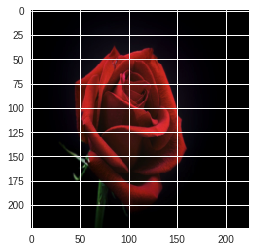

In [0]:
from PIL import Image
# from matplotlib.pyplot import imshow

#pillow image
pil_img = Image.open(os.path.join(DIR, "red_rose.jpg"))

#tensor image
tensor_img = process_image(pil_img)

#show that tensor image
show_tensor_image2(tensor_img)

In [0]:
#make sure the tensor is as expected
tensor_img.shape

torch.Size([1, 3, 224, 224])

### Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data. Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
prediction = loaded_vgg(tensor_img)  # Returns a Tensor of shape (batch, num class labels)
# prediction = prediction.data.numpy().argmax()  # Our prediction will be the index of the class label with the largest value.
# print(prediction)  
# print(labels[prediction])  # Converts the index to a string using our labels dict

In [0]:
# torch.exp(prediction.topk(5))
prediction.topk(5)[0]

tensor([[9.9483, 9.5216, 7.6959, 6.8696, 5.5622]], device='cuda:0',
       grad_fn=<TopkBackward>)

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file   
    im = Image.open("bride.jpg")
    prediction = vgg(img)  # Returns a Tensor of shape (batch, num class labels)
    prediction = prediction.data.numpy().argmax()  # Our prediction will be the index of the class label with the largest value.
    print labels[prediction]  # Converts the index to a string using our labels dict

### Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes